# Manifold

author: steeve.laquitaine@epfl.ch  

**method**:

* task parameters (see bbp_workflow config):
    * start delay: 1000 ms
    * stimulus delay: 1500 ms
    * 360 stimuli x 50 repeated trials for characterizing the tuning curves
    * interstimulus interval: 200 ms


* data:
    1. 36 simulation files
    2. bbp_workflow config script spikesorting_stim_rotations.py indicates 36 files with orientations for file 1: 0 to 9, file 2: 10 to 19 etc...
    3. png files confirm point 2): /gpfs/bbp.cscs.ch/project/proj83/scratch/home/isbister/post_physiology_2023/sim_data/campaigns/spikesorting_stimulus_tests/4_spikesorting_stimulus_test_neuropixels_8-1-24/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/35
    5. Thus: Each simulation file is organized as: simulation file duration (101500 ms) = start delay of 1500 ms then 10 repeats of (orientation for 9800 ms followed by 200 ms of ISI)


Starting from:
* Manifold of ground truth [done]  
* Manifold of spike sorted single-units (isolated with KSLabel only, has all the single-unit biases) -> what the best sorters produce.  

Qualitative impact of biases:
* Manifold of single-units (only the predominant **mixed:overmerging + oversplitting** type) -> isolate the effect of the biases.
* Manifold of spike sorted single-units (overmerging only type) -> isolate the effect of overmerging.
* Manifold of spike sorted single-units (oversplitting type) -> isolate the effect of oversplitting.
* Manifold including multi-units (with multi-units, cite Shenoy's work) and its discrimination capacity -> the worst case (all biases).

Quantitative: discrimination capacities (and manifolds?) after sorted unit curation with our model -> significant improvement

Our improvement:
* above with our novel curation method -> improvement

### Requirements

* https://github.com/schung039/neural_manifolds_replicaMFT.git

### Setup

Setup `manifold` env

In [2]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.decomposition import PCA # dimensionality reduction
from mftma.manifold_analysis_correlation import manifold_analysis_corr
import random
import seaborn as sns
from collections import defaultdict
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
from scipy.stats import kruskal  # stats
import scikit_posthocs as sp


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes import utils
from src.nodes.utils import get_config
from src.nodes.analysis.code import igeom

# SETUP CONFIG
data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT = data_conf["sorting"]["simulation"]["ground_truth"]["full"]["output"]
REC = data_conf["probe_wiring"]["output"]
IGEOM = data_conf["analyses"]["neural_code"]["igeom"]
IGEOM_BY_Q = data_conf["analyses"]["neural_code"]["by_quality"]["igeom"]

# SORTINGS
K4 = data_conf["sorting"]["sorters"]["kilosort4"]["full"]["output"]
K3 = data_conf["sorting"]["sorters"]["kilosort3"]["full"]["output"]
K25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["full"]["output"]
K2 = data_conf["sorting"]["sorters"]["kilosort2"]["full"]["output"]
KS = data_conf["sorting"]["sorters"]["kilosort"]["full"]["output"]
HS = data_conf["sorting"]["sorters"]["herdingspikes"]["full"]["output"]


# SETUP QUALITY PATH
quality_path = "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
SELECT_PERIOD = False

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-10-16 16:47:41,170 - root - utils.py - get_config - INFO - Reading experiment config.
2024-10-16 16:47:41,292 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Load datasets

In [3]:
# get sorted unit quality classification
quality_df = pd.read_csv(quality_path)

# get true evoked ata
SortingTrue = si.load_extractor(GT)
Recording = si.load_extractor(REC)
duration_secs = Recording.get_total_duration()
SFREQ = SortingTrue.get_sampling_frequency()

# get SortingExtractors
SortingK4 = si.load_extractor(K4)
SortingK3 = si.load_extractor(K3)
SortingK25 = si.load_extractor(K25)
SortingK2 = si.load_extractor(K2)
SortingKS = si.load_extractor(KS)
SortingHS = si.load_extractor(HS)

# get task epoch infos
task = igeom.get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
)

# get stimulus directions and intervals (ms)
stimulus_labels = igeom.get_stimulus_labels()
stimulus_intervals_ms = igeom.get_stimulus_intervals_ms(
    task["epoch_labels"], task["epoch_ms"]
)

# parameters

# takes 20 secs
FIG_SIZE = (6, 10)
N_PANELS = 7

# set parameters
params = {"orientations": stimulus_labels}
params_pca = {
    "dims": 3,  # dimensions
    "orientations": params["orientations"],  # stimulus orientations
}

# compute unit x stimulus response matrix
gt_resp = igeom.compute_response_by_stim_matrix(
    SortingTrue.unit_ids, SortingTrue, stimulus_intervals_ms
)

# setup SortingExtractors
# with single-unit curation
sortingextractors1 = [
    SortingK4,
    SortingK3,
    SortingK25,
    SortingK2,
]
# no single-unit curation
sortingextractors2 = [SortingKS, SortingHS]

print(f"stimulus directions {stimulus_labels.shape}: {stimulus_labels}")
print(f"stimulus intervals (ms)({len(stimulus_intervals_ms)}): {stimulus_intervals_ms}")

# load precomputed information geometry metrics
df = pd.read_csv(IGEOM)
display(df)

stimulus directions (18000,): [  0   0   0 ... 359 359 359]
stimulus intervals (ms)(18000): [(500, 700), (700, 900), (900, 1100), (1100, 1300), (1300, 1500), (1500, 1700), (1700, 1900), (1900, 2100), (2100, 2300), (2300, 2500), (2500, 2700), (2700, 2900), (2900, 3100), (3100, 3300), (3300, 3500), (3500, 3700), (3700, 3900), (3900, 4100), (4100, 4300), (4300, 4500), (4500, 4700), (4700, 4900), (4900, 5100), (5100, 5300), (5300, 5500), (5500, 5700), (5700, 5900), (5900, 6100), (6100, 6300), (6300, 6500), (6500, 6700), (6700, 6900), (6900, 7100), (7100, 7300), (7300, 7500), (7500, 7700), (7700, 7900), (7900, 8100), (8100, 8300), (8300, 8500), (8500, 8700), (8700, 8900), (8900, 9100), (9100, 9300), (9300, 9500), (9500, 9700), (9700, 9900), (9900, 10100), (10100, 10300), (10300, 10500), (10500, 10700), (10700, 10900), (10900, 11100), (11100, 11300), (11300, 11500), (11500, 11700), (11700, 11900), (11900, 12100), (12100, 12300), (12300, 12500), (12500, 12700), (12700, 12900), (12900, 13100),

,Capacity,Unit class,Sorter
0,0.841072,ground_truth,ground_truth
1,1.328917,ground_truth,ground_truth
2,1.844061,ground_truth,ground_truth
3,1.675842,ground_truth,ground_truth
4,2.042863,ground_truth,ground_truth
...,...,...,...
535,1.058452,mixed: overmerger + oversplitter,HS
536,1.305912,mixed: overmerger + oversplitter,HS
537,0.980194,mixed: overmerger + oversplitter,HS
538,1.004978,mixed: overmerger + oversplitter,HS


## Plot manifolds

### (20s) Single-units

* all 360 whisker deflection directions are represented
* that is the best output produced by the spike sorters

manifold axis max: 1.0
manifold axis min: -0.5180597493925809
manifold axis max: 1.0
manifold axis min: -0.2867780338810337
manifold axis max: 1.0
manifold axis min: -0.44477012736117005
manifold axis max: 1.0
manifold axis min: -0.3322794783020172
manifold axis max: 1.0
manifold axis min: -0.3680905126751308
manifold axis max: 1.0
manifold axis min: -0.24925116510016554
manifold axis max: 1.0
manifold axis min: -0.44867335821722276


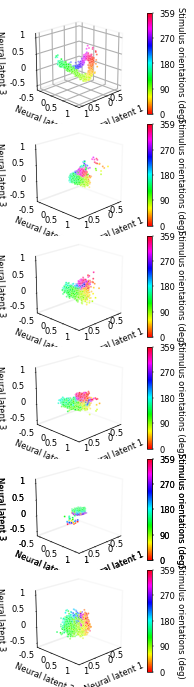

In [43]:
# plot
fig = plt.figure(figsize=FIG_SIZE)

# panel 1: ground truth
ax = fig.add_subplot(N_PANELS, 1, 1, projection="3d")
manifold = igeom.plot_manifold_from_pca(gt_resp, params_pca, ax, axis_lim=[-0.6, 1.1])

# panels 2 to 4: loop over sorters (w/ single-unit curation)
# record
# sorters name are standardized as in the quality table
# loaded below
sorter = ["KS4", "KS3", "KS2.5", "KS2"]

# plot
out_data = dict()
c_ix = 0
for s_ix, Sorting in enumerate(sortingextractors1, start=2):
    ax = fig.add_subplot(N_PANELS, 1, s_ix, projection="3d")
    out_data[sorter[c_ix]] = igeom.plot_sorted_manifolds2(
        ax, Sorting, stimulus_intervals_ms, params_pca, axis_lim=[-0.6, 1.1]
    )
    c_ix += 1
    ax.grid(False)

# panels 5 and 6: loop over KS and HS (no single-unit curation)
# record
sorter = ["KS", "HS"]

# plot
c_ix = 0
for s_ix, Sorting in enumerate(sortingextractors2, start=5):
    ax = fig.add_subplot(N_PANELS, 1, s_ix, projection="3d")
    out_data[sorter[c_ix]] = igeom.plot_all_sorted_unit_manifolds2(
        ax, Sorting, stimulus_intervals_ms, params_pca, axis_lim=[-0.6, 1.1]
    )
    c_ix += 1
    ax.grid(False)

# tidy up
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# save figure
utils.savefig(PROJ_PATH + "/figures/4_code/single_unit_manifolds.svg")

## Capacity by sorter by quality

* **Class manifold**: "The set of all state vectors corresponding to responses to all possible stimuli associated with the same object can be viewed as a manifold in the neural state space” [Chung et al., 2017]
* The **load**: of the neural population is alpha = P/N.
* The **manifold capacity**:
    * is the critical load: alpha_c. It is the critical number of object manifolds, P, that can be linearly separated (by a linear hyperplane through the origin [Chung et al., 2017]) given N features. It is the linearly decodable information about object per unit. 
    * It captures the linear separability of object manifolds. 
    * If the load alpha=P/N is below the manifold capacity alpha_c, most object manifold are separable, else most are inseparable.
    * **lower bound**: “The manifold capacity for point-cloud manifolds is lower bounded by the case where there is no manifold structure.” [Stephenson et al., 2020]
* The **manifold dimension**:
    * upper bound is min(M,N) where M is the number of points per manifold (50 sample instances in our case) and N is the number of units.

* The **Margin**: 
    * “The robustness of a linear classifier is quantified by the margin, which measures the distance between the separating hyperplane and the closest point.” [Chung et al., 2017]

Method:
* the unit populations have different unit sizes, so the manifold capacity must be normalized.


* Observations:
    * true manifold has a lower radius, dimensionality and centroid correlation, which explain why it also shows higher capacity than the spike-sorted datasets, as expected.
    * lower centroid correlation would be expected, but its centroid correlation is higher than the other two conditions' correlations.

In [4]:
def get_block_paths(igeom_path, blocks):
    b_paths = []
    for b_i in blocks:
        if len(str(b_i)) == 1:
            flag = "0" + str(b_i) + "_1"
        else:
            flag = str(b_i) + "_1"
        b_paths.append(igeom_path + "_" + flag + ".csv")
    return b_paths

In [7]:
N_BLOCKS = 1

# get blocks' paths
blocks = np.arange(0, N_BLOCKS, 1)
igeom_path = os.path.splitext(IGEOM)[0]
b_paths = get_block_paths(igeom_path, blocks)
display(b_paths)

df_all = []
for p_i in b_paths:
    df_all.append(pd.read_csv(p_i))

df_all = pd.concat(df_all)

['/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/preprint_2024/realism/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/neural_code/igeometrics_00_1.csv']

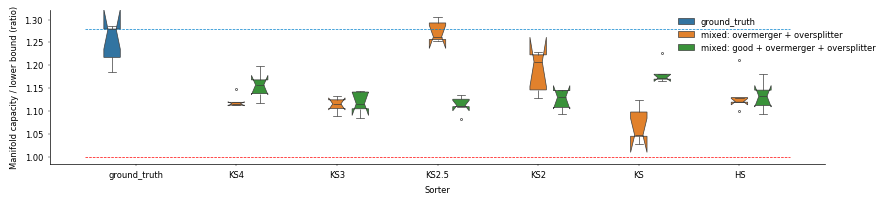

In [9]:
# set plot parameters
BOXPLOT_PMS = {
    "notch": True,
    "gap": 0.3,
    "width": 0.7,
    "linewidth": 0.5,
    "flierprops": {
        "marker": "o",
        "markerfacecolor": "w",
        "markersize": 1.5,
        "markeredgewidth": 0.5,
    },
}

# fig, ax = plt.subplots(1, 1, figsize=(5, 2))
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

# plot
ax = sns.boxplot(
    ax=ax,
    data=df_all,
    x="Sorter",  # "Sorter",
    # x="Unit class",  # "Sorter",
    y="Capacity",
    hue="Unit class",
    hue_order=[
        "ground_truth",
        "mixed: overmerger + oversplitter",
        # "multi-unit",
        # "all sorted units",
        # "single-unit",
        "mixed: good + overmerger + oversplitter",
    ],
    # palette=[cl["COLOR_NV"], cl["COLOR_NS"], cl["COLOR_NE"], cl["COLOR_NB"]],
    **BOXPLOT_PMS,
)
ax.hlines(xmin=-0.5, xmax=6.5, y=1, color="r", linestyle="--")

mean_gt = df_all[df_all["Unit class"] == "ground_truth"].Capacity.median()
ax.hlines(
    xmin=-0.5,
    xmax=6.5,
    y=mean_gt,
    color=[0, 0.5, 0.8],
    linestyle="--",
)
ax.set_ylabel("Manifold capacity / lower bound (ratio)")

ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))

# save
utils.savefig(
    PROJ_PATH + "/figures/4_code/assets/fig7B_capacity_by_sortibng.svg",
)

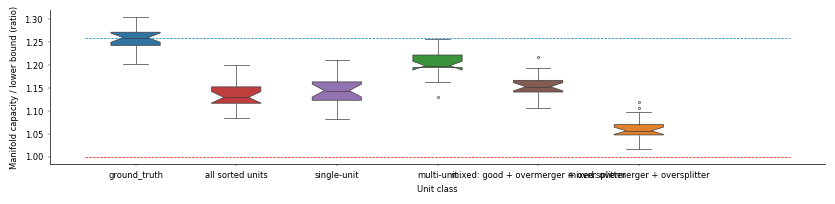

In [13]:
# df_all = pd.read_csv(IGEOM_BY_Q)

# # set plot parameters
# BOXPLOT_PMS = {
#     "notch": True,
#     "gap": 0.3,
#     "width": 0.7,
#     "linewidth": 0.5,
#     "flierprops": {
#         "marker": "o",
#         "markerfacecolor": "w",
#         "markersize": 1.5,
#         "markeredgewidth": 0.5,
#     },
# }

# # fig, ax = plt.subplots(1, 1, figsize=(5, 2))
# fig, ax = plt.subplots(1, 1, figsize=(10, 2))

# # plot
# ax = sns.boxplot(
#     ax=ax,
#     data=df_all,
#     x="Unit class",
#     y="Capacity",
#     hue="Unit class",
#     hue_order=[
#         "ground_truth",
#         "mixed: overmerger + oversplitter",
#         "multi-unit",
#         "all sorted units",
#         "single-unit",
#         "mixed: good + overmerger + oversplitter",
#     ],
#     # palette=[cl["COLOR_NV"], cl["COLOR_NS"], cl["COLOR_NE"], cl["COLOR_NB"]],
#     **BOXPLOT_PMS,
# )
# ax.hlines(xmin=-0.5, xmax=6.5, y=1, color="r", linestyle="--")

# mean_gt = df_all[df_all["Unit class"] == "ground_truth"].Capacity.median()
# ax.hlines(
#     xmin=-0.5,
#     xmax=6.5,
#     y=mean_gt,
#     color=[0, 0.5, 0.8],
#     linestyle="--",
# )
# ax.set_ylabel("Manifold capacity / lower bound (ratio)")
# ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))

# # # save
# # utils.savefig(
# #     PROJ_PATH + "/figures/4_code/fig7A_capacity.svg",
# # )

In [46]:
def get_data_for_stats(df_all, sorter="KS4"):
    oo = df_all[
        (df_all.Sorter == sorter)
        & (df_all["Unit class"] == "mixed: overmerger + oversplitter")
    ].Capacity.values
    mu = df_all[
        (df_all.Sorter == sorter) & (df_all["Unit class"] == "multi-unit")
    ].Capacity.values
    all = df_all[
        (df_all.Sorter == sorter) & (df_all["Unit class"] == "all sorted units")
    ].Capacity.values
    su = df_all[
        (df_all.Sorter == sorter) & (df_all["Unit class"] == "single-unit")
    ].Capacity.values
    g = df_all[
        (df_all.Sorter == sorter)
        & (df_all["Unit class"] == "mixed: good + overmerger + oversplitter")
    ].Capacity.values
    return {"data": [oo, mu, all, su, g], "name": ["oo", "mu", "all", "su", "g"]}


def get_kk(df, sorter):
    """kruskall wallis test"""

    data = get_data_for_stats(df, sorter=sorter)

    d_all = []
    d_name = []
    for d_i, data_i in enumerate(data["data"]):
        if not len(data_i) == 0:
            d_all.append(data_i)
            d_name.append(data["name"][d_i])
            print(f"""N {data["name"][d_i]} = {len(data_i)}""")

    # get stats
    h, p = kruskal(*d_all)
    print(f"""h={h}, p={p}""")
    return d_all, d_name


def get_posthoc_dunn_holm_sidak(data, var_names=["oo", "mu", "all", "su", "g"]):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = var_names
    df.index = var_names
    return df

### Stats

* kruskall wallis with posthoc dunn holm sidak

In [47]:
data, names = get_kk(df, "KS4")
get_posthoc_dunn_holm_sidak(data, var_names=names)

N oo = 20
N mu = 20
N all = 20
N su = 20
N g = 20
h=29.680752475247516, p=5.684234461793255e-06


,oo,mu,all,su,g
oo,1.000000,0.241137,0.018368,0.000008,0.000473
mu,0.241137,1.000000,0.601123,0.018368,0.176096
all,0.018368,0.601123,1.000000,0.241137,0.601123
su,0.000008,0.018368,0.241137,1.000000,0.601123
g,0.000473,0.176096,0.601123,0.601123,1.000000


In [208]:
data, names = get_kk(df, "KS3")
get_posthoc_dunn_holm_sidak(data, var_names=names)

N oo = 20
N mu = 20
N all = 20
N su = 20
N g = 20
h=21.139009900990118, p=0.0002971919898479569


,oo,mu,all,su,g
oo,1.000000,0.300737,0.121056,0.000313,0.002833
mu,0.300737,1.000000,0.818997,0.152599,0.338314
all,0.121056,0.818997,1.000000,0.338314,0.548165
su,0.000313,0.152599,0.338314,1.000000,0.818997
g,0.002833,0.338314,0.548165,0.818997,1.000000


In [209]:
data, names = get_kk(df, "KS2.5")
get_posthoc_dunn_holm_sidak(data, var_names=names)

N oo = 20
N mu = 20
N all = 20
N su = 20
N g = 20
h=17.866336633663366, p=0.0013105756320218186


,oo,mu,all,su,g
oo,1.000000,0.555724,0.000426,0.351107,0.148933
mu,0.555724,1.000000,0.050354,0.846679,0.683609
all,0.000426,0.050354,1.000000,0.148933,0.351107
su,0.351107,0.846679,0.148933,1.000000,0.846679
g,0.148933,0.683609,0.351107,0.846679,1.000000


In [213]:
data, names = get_kk(df, "KS2")
get_posthoc_dunn_holm_sidak(data, var_names=names)

N oo = 20
N mu = 20
N all = 20
N su = 20
N g = 20
h=23.699405940594033, p=9.175557826263358e-05


,oo,mu,all,su,g
oo,1.000000,0.004951,0.000357,0.000265,0.015242
mu,0.004951,1.000000,0.898650,0.898650,0.921078
all,0.000357,0.898650,1.000000,0.926181,0.828580
su,0.000265,0.898650,0.926181,1.000000,0.828580
g,0.015242,0.921078,0.828580,0.828580,1.000000


In [211]:
data, names = get_kk(df, "KS")
get_posthoc_dunn_holm_sidak(data, var_names=names)

N oo = 20
N all = 20
N g = 20
h=10.34655737704918, p=0.005665961409284313


,oo,all,g
oo,1.000000,0.644273,0.022944
all,0.644273,1.000000,0.008409
g,0.022944,0.008409,1.000000


In [214]:
data, names = get_kk(df, "HS")
get_posthoc_dunn_holm_sidak(data, var_names=names)

N oo = 20
N all = 20
N g = 20
h=11.026557377049187, p=0.0040328631810467724


,oo,all,g
oo,1.000000,0.59323,0.020166
all,0.593230,1.00000,0.005690
g,0.020166,0.00569,1.000000


#### Radius

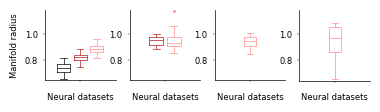

In [139]:
# GAP = 0.2
# MARKERSIZE = 2
# YLIM = [0.65, 1.18]
# fig, axes = plt.subplots(1, 4, figsize=(4.2, 1))

# # KS 3.0 --------------------

# plot_data = pd.DataFrame()
# plot_data["Truth"] = out_true["true_units"][0]["metrics_per_class"]["radius"]
# plot_data["Sorted single units"] = out_ks3["sorted_single_unit"][0][
#     "metrics_per_class"
# ]["radius"]
# plot_data["All sorted units"] = out_ks3["all_sorted_units"][0]["metrics_per_class"][
#     "radius"
# ]
# plot_data = plot_data.melt()

# ax = sns.boxplot(
#     ax=axes[0],
#     data=plot_data,
#     hue="variable",
#     y="value",
#     fill=False,
#     palette=colors,
#     gap=GAP,
#     linewidth=plt.rcParams["lines.linewidth"],
#     flierprops={"marker": ".", "markersize": MARKERSIZE},
#     width=0.7,
# )
# axes[0].set_box_aspect(1)
# axes[0].spines[["top", "right"]].set_visible(False)
# axes[0].get_legend().remove()
# # axes[0].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[0].set_ylabel("Manifold radius")
# axes[0].set_xlabel("Neural datasets")
# axes[0].set_ylim(YLIM)

# # KS 2.5 --------------------

# plot_data = pd.DataFrame()
# plot_data["Sorted single units"] = (
#     out_ks2_5["sorted_single_unit"][0]["metrics_per_class"]["radius"]
#     / out_ks2_5["sorted_single_unit"][1]["metrics_per_class"]["radius"]
# )
# plot_data["All sorted units"] = (
#     out_ks2_5["all_sorted_units"][0]["metrics_per_class"]["radius"]
#     / out_ks2_5["all_sorted_units"][1]["metrics_per_class"]["radius"]
# )
# plot_data = plot_data.melt()

# ax = sns.boxplot(
#     ax=axes[1],
#     data=plot_data,
#     hue="variable",
#     y="value",
#     fill=False,
#     palette=colors[1:],
#     gap=GAP,
#     linewidth=plt.rcParams["lines.linewidth"],
#     flierprops={"marker": ".", "markersize": MARKERSIZE},
#     width=0.5,
# )
# axes[1].set_box_aspect(1)
# axes[1].get_legend().remove()
# # axes[1].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[1].spines[["top", "right"]].set_visible(False)
# axes[1].set_xlabel("Neural datasets")
# axes[1].set_ylim(YLIM)
# axes[1].set_ylabel("")

# # HS --------------------

# plot_data = pd.DataFrame()
# plot_data["All sorted units"] = (
#     out_hs["all_sorted_units"][0]["metrics_per_class"]["radius"]
#     / out_hs["all_sorted_units"][1]["metrics_per_class"]["radius"]
# )
# plot_data = plot_data.melt()

# ax = sns.boxplot(
#     ax=axes[2],
#     data=plot_data,
#     hue="variable",
#     y="value",
#     fill=False,
#     palette=colors[2:],
#     gap=GAP,
#     linewidth=plt.rcParams["lines.linewidth"],
#     flierprops={"marker": ".", "markersize": MARKERSIZE},
#     width=0.2,
# )
# axes[2].set_box_aspect(1)
# # axes[2].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[2].get_legend().remove()
# axes[2].spines[["top", "right"]].set_visible(False)
# axes[2].set_xlabel("Neural datasets")
# axes[2].set_ylim(YLIM)
# axes[2].set_ylabel("")
# # KS --------------------

# plot_data = pd.DataFrame()
# plot_data["All sorted units"] = (
#     out_ks["all_sorted_units"][0]["metrics_per_class"]["radius"]
#     / out_ks["all_sorted_units"][1]["metrics_per_class"]["radius"]
# )
# plot_data = plot_data.melt()

# ax = sns.boxplot(
#     ax=axes[3],
#     data=plot_data,
#     hue="variable",
#     y="value",
#     fill=False,
#     palette=colors[2:],
#     gap=GAP,
#     linewidth=plt.rcParams["lines.linewidth"],
#     flierprops={"marker": ".", "markersize": MARKERSIZE},
#     width=0.2,
# )
# axes[3].set_box_aspect(1)
# # axes[3].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[3].get_legend().remove()
# axes[3].spines[["top", "right"]].set_visible(False)
# axes[3].set_xlabel("Neural datasets")
# axes[3].set_ylabel("")
# axes[3].set_ylim(YLIM)

# # fig.subplots_adjust(wspace=0.5, hspace=0.1)

# plt.savefig(
#     "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/4_neural_code/svg/manifold_radii.svg",
#     **savefig_cfg,
# )

#### Dimension

We could normalize by min(M,N) the upper bound dimensionality but we already use Gaussian random projection to reduce and standardize 
the unit feature dimensionality of all response matrices to `N_new`.

In that case the upper bound dimensionality for all neural datasets is min(M=50, N=200) = 50, the number of sample per class.

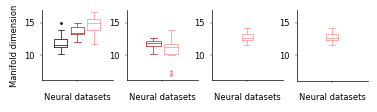

In [138]:
# GAP = 0.2
# MARKERSIZE = 2
# METRICS = "dimension"
# YLIM = [6, 17]
# fig, axes = plt.subplots(1, 4, figsize=(4.2, 1))

# # KS 3.0 --------------------

# plot_data = pd.DataFrame()
# plot_data["Truth"] = out_true["true_units"][0]["metrics_per_class"][METRICS]
# plot_data["Sorted single units"] = out_ks3["sorted_single_unit"][0][
#     "metrics_per_class"
# ][METRICS]
# plot_data["All sorted units"] = out_ks3["all_sorted_units"][0]["metrics_per_class"][
#     METRICS
# ]
# plot_data = plot_data.melt()

# # plot
# ax = sns.boxplot(
#     ax=axes[0],
#     data=plot_data,
#     hue="variable",
#     y="value",
#     fill=False,
#     palette=colors,
#     gap=GAP,
#     linewidth=plt.rcParams["lines.linewidth"],
#     flierprops={"marker": ".", "markersize": MARKERSIZE},
#     width=0.7,
# )
# axes[0].set_box_aspect(1)
# axes[0].spines[["top", "right"]].set_visible(False)
# axes[0].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[0].get_legend().remove()
# axes[0].set_ylabel("Manifold dimension")
# axes[0].set_xlabel("Neural datasets")
# axes[0].set_ylim(YLIM)

# # KS 2.5 --------------------

# plot_data = pd.DataFrame()
# plot_data["Sorted single units"] = out_ks2_5["sorted_single_unit"][0][
#     "metrics_per_class"
# ][METRICS]
# plot_data["All sorted units"] = out_ks2_5["all_sorted_units"][0]["metrics_per_class"][
#     METRICS
# ]
# plot_data = plot_data.melt()

# # plot
# ax = sns.boxplot(
#     ax=axes[1],
#     data=plot_data,
#     hue="variable",
#     y="value",
#     fill=False,
#     palette=colors[1:],
#     gap=GAP,
#     linewidth=plt.rcParams["lines.linewidth"],
#     flierprops={"marker": ".", "markersize": MARKERSIZE},
#     width=0.5,
# )
# axes[1].set_box_aspect(1)
# # axes[1].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[1].get_legend().remove()
# axes[1].spines[["top", "right"]].set_visible(False)
# axes[1].set_ylabel("")
# axes[1].set_xlabel("Neural datasets")
# axes[1].set_ylim(YLIM)


# # HS --------------------

# plot_data = pd.DataFrame()
# plot_data["All sorted units"] = out_hs["all_sorted_units"][0]["metrics_per_class"][
#     METRICS
# ]
# plot_data = plot_data.melt()

# # plot
# ax = sns.boxplot(
#     ax=axes[2],
#     data=plot_data,
#     hue="variable",
#     y="value",
#     fill=False,
#     palette=colors[2:],
#     gap=GAP,
#     linewidth=plt.rcParams["lines.linewidth"],
#     flierprops={"marker": ".", "markersize": MARKERSIZE},
#     width=0.2,
# )
# axes[2].set_box_aspect(1)
# # axes[2].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[2].get_legend().remove()
# axes[2].spines[["top", "right"]].set_visible(False)
# axes[2].set_ylabel("")
# axes[2].set_xlabel("Neural datasets")
# axes[2].set_ylim(YLIM)

# # KS --------------------

# plot_data = pd.DataFrame()
# plot_data["All sorted units"] = out_hs["all_sorted_units"][0]["metrics_per_class"][
#     METRICS
# ]
# plot_data = plot_data.melt()

# # plot
# ax = sns.boxplot(
#     ax=axes[3],
#     data=plot_data,
#     hue="variable",
#     y="value",
#     fill=False,
#     palette=colors[2:],
#     gap=GAP,
#     linewidth=plt.rcParams["lines.linewidth"],
#     flierprops={"marker": ".", "markersize": MARKERSIZE},
#     width=0.2,
# )
# axes[3].set_box_aspect(1)
# # axes[3].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[3].get_legend().remove()
# axes[3].spines[["top", "right"]].set_visible(False)
# axes[3].set_ylabel("")
# axes[3].set_xlabel("Neural datasets")
# axes[3].set_ylim(YLIM)

# # save fig
# plt.savefig(
#     PROJ_PATH + "/figures/4_neural_code/svg/manifold_dimension.svg",
#     **savefig_cfg,
# )

#### Centroid correlation

2024-02-24 14:18:20,000 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[0.07061305111261482, 0.06949389406294815, 0.07005654961150318]
[0.07061305111261482, 0.07060403837503196, 0.07043657025634727]


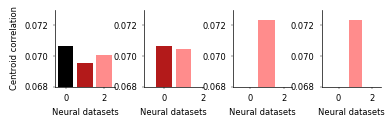

In [137]:
# GAP = 0.2
# MARKERSIZE = 2
# METRICS = "correlation"
# YLIM = [0.068, 0.073]
# fig, axes = plt.subplots(1, 4, figsize=(4.2, 1))

# # KS 3.0 --------------------

# true_corr = out_true["true_units"][0]["metrics_per_class"][METRICS]
# sorted_single_unit_corr_ks3 = out_ks3["sorted_single_unit"][0]["metrics_per_class"][
#     METRICS
# ]
# all_sorted_unit_corr_ks3 = out_ks3["all_sorted_units"][0]["metrics_per_class"][METRICS]

# # plot
# axes[0].bar(
#     [0, 1, 2],
#     [true_corr, sorted_single_unit_corr_ks3, all_sorted_unit_corr_ks3],
#     color=colors,
# )

# # add legend
# axes[0].spines[["top", "right"]].set_visible(False)
# axes[0].legend(frameon=False, loc="upper left", bbox_to_anchor=(0.8, 1))
# axes[0].set_ylabel("Centroid correlation")
# axes[0].set_xlabel("Neural datasets")
# axes[0].set_ylim(YLIM)

# # KS 2.5 --------------------

# sorted_single_unit_corr_ks2_5 = out_ks2_5["sorted_single_unit"][0]["metrics_per_class"][
#     METRICS
# ]
# all_sorted_unit_corr_ks2_5 = out_ks2_5["all_sorted_units"][0]["metrics_per_class"][
#     METRICS
# ]

# # plot
# axes[1].bar(
#     [0, 1],
#     [sorted_single_unit_corr_ks2_5, all_sorted_unit_corr_ks2_5],
#     color=colors[1:],
#     width=0.8,
# )

# # add legend
# axes[1].spines[["top", "right"]].set_visible(False)
# axes[1].set_ylabel("")
# axes[1].set_xlabel("Neural datasets")
# axes[1].set_ylim(YLIM)
# axes[1].set_xlim([-1, 2])

# # HS --------------------

# all_sorted_unit_corr_hs = out_hs["all_sorted_units"][0]["metrics_per_class"][METRICS]

# # plot
# axes[2].bar([1], [all_sorted_unit_corr_hs], color=colors[2:], width=1)

# # add legend
# axes[2].spines[["top", "right"]].set_visible(False)
# axes[2].set_ylabel("")
# axes[2].set_xlabel("Neural datasets")
# axes[2].set_ylim(YLIM)
# axes[2].set_xlim([-1, 2.5])

# # KS --------------------

# all_sorted_unit_corr_ks = out_hs["all_sorted_units"][0]["metrics_per_class"][METRICS]

# # plot
# axes[3].bar([1], [all_sorted_unit_corr_ks], color=colors[2:])

# # add legend
# axes[3].spines[["top", "right"]].set_visible(False)
# axes[3].set_ylabel("")
# axes[3].set_xlabel("Neural datasets")
# axes[3].set_ylim(YLIM)
# axes[3].set_xlim([-1, 2.5])

# fig.subplots_adjust(wspace=0.5, hspace=0.1)

# plt.savefig(
#     "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/figures/4_neural_code/svg/manifold_correlation.svg",
#     **savefig_cfg,
# )

# print([true_corr, sorted_single_unit_corr_ks3, all_sorted_unit_corr_ks3])
# print([true_corr, sorted_single_unit_corr_ks2_5, all_sorted_unit_corr_ks2_5])